In [1]:
import numpy
print(numpy.__version__)
from catboost import CatBoostRegressor

1.26.4


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

### Import the CSV Data as Pandas DataFrame

In [4]:
df = pd.read_csv('data/raw.csv')

### Show top 5 Records

In [5]:
df.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,math_score,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


### Preparing X and Y variables

In [7]:
X = df.drop(columns=['math_score'], axis=1)

In [8]:
X.head()

,gender,race_ethnicity,parental_level_of_education,lunch,test_preparation_course,reading_score,writing_score
0,female,group B,bachelor's degree,standard,none,72,74
1,female,group C,some college,standard,completed,90,88
2,female,group B,master's degree,standard,none,95,93
3,male,group A,associate's degree,free/reduced,none,57,44
4,male,group C,some college,standard,none,78,75


In [9]:
print("Categories in 'gender' variable: ", end=" ")
print(df['gender'].unique())

print("Categories in 'race_ethnicity' variable: ", end=" ")
print(df['race_ethnicity'].unique())

print("Categories in 'parental level of education' variable: ", end=" ")
print(df['parental_level_of_education'].unique())

print("Categories in 'lunch' variable: ", end=" ")
print(df['lunch'].unique())

print("Categories in 'test preparation course' variable: ", end=" ")
print(df['test_preparation_course'].unique())

Categories in 'gender' variable:  ['female' 'male']
Categories in 'race_ethnicity' variable:  ['group B' 'group C' 'group A' 'group D' 'group E']
Categories in 'parental level of education' variable:  ["bachelor's degree" 'some college' "master's degree" "associate's degree"
 'high school' 'some high school']
Categories in 'lunch' variable:  ['standard' 'free/reduced']
Categories in 'test preparation course' variable:  ['none' 'completed']


In [10]:
y = df['math_score']

In [11]:
y

0      72
1      69
2      90
3      47
4      76
       ..
995    88
996    62
997    59
998    68
999    77
Name: math_score, Length: 1000, dtype: int64

In [18]:
# create column transformer with 3 type of transformers
num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoding", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [19]:
X = preprocessor.fit_transform(X)

In [24]:
pd.DataFrame(X).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.193999,0.391492
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.427476,1.313269
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.770109,1.642475
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.833899,-1.583744
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.605158,0.457333


In [22]:
X.shape

(1000, 19)

In [25]:
# separate dataset into train and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((800, 19), (200, 19))

## Create an Evaluate Function to give all metrics after Model Training

In [27]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mse)
    r2_square = r2_score(true, predicted)

    return mae, rmse, r2_square

In [29]:
models = {
    'Linear Regreesion': LinearRegression(),
    'Lasse': Lasso(),
    'Ridge': Ridge(),
    'K-Neighbors Regressor': KNeighborsRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'CatBoosting Regressor': CatBoostRegressor(verbose=False),
    'AdaBoost Regressor': AdaBoostRegressor()
}
model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train mdoel

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model Performance for Training Set')
    print("- Root Mean Square Error: {:.4f}".format(model_train_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_train_mae))
    print('- R2 Score: {:.4f}'.format(model_train_r2))

    print('_'*35)

    print('Model Performance for Test Set')
    print("- Root Mean Square Error: {:.4f}".format(model_test_rmse))
    print('- Mean Absolute Error: {:.4f}'.format(model_test_mae))
    print('- R2 Score: {:.4f}'.format(model_test_r2))
    r2_list.append(model_test_r2)

    print('-'*35)
    print('\n')

Linear Regreesion
Model Performance for Training Set
- Root Mean Square Error: 5.3257
- Mean Absolute Error: 4.2695
- R2 Score: 0.8742
___________________________________
Model Performance for Test Set
- Root Mean Square Error: 5.4212
- Mean Absolute Error: 4.2347
- R2 Score: 0.8792
-----------------------------------


Lasse
Model Performance for Training Set
- Root Mean Square Error: 6.5938
- Mean Absolute Error: 5.2063
- R2 Score: 0.8071
___________________________________
Model Performance for Test Set
- Root Mean Square Error: 6.5197
- Mean Absolute Error: 5.1579
- R2 Score: 0.8253
-----------------------------------


Ridge
Model Performance for Training Set
- Root Mean Square Error: 5.3233
- Mean Absolute Error: 4.2650
- R2 Score: 0.8743
___________________________________
Model Performance for Test Set
- Root Mean Square Error: 5.3904
- Mean Absolute Error: 4.2111
- R2 Score: 0.8806
-----------------------------------


K-Neighbors Regressor
Model Performance for Training Set
-

In [34]:
pd.DataFrame({"Model":model_list,
              "R2 Scores": r2_list}).sort_values('R2 Scores', ascending=False)

,Model,R2 Scores
2,Ridge,0.880593
0,Linear Regreesion,0.879226
8,AdaBoost Regressor,0.852674
7,CatBoosting Regressor,0.851632
5,Random Forest Regressor,0.849484
6,XGBRegressor,0.827797
1,Lasse,0.825320
3,K-Neighbors Regressor,0.783813
4,Decision Tree,0.764443


## Linear Regression

In [36]:
# lin_model = LinearRegression(fit_intercept=True)
lin_model =Ridge(fit_intercept=True)
lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 88.06


## Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

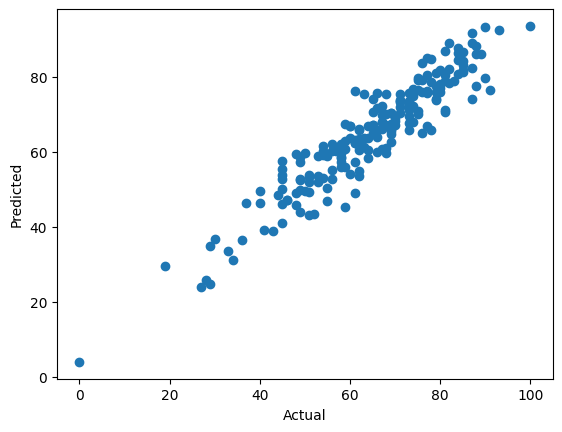

In [37]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='math_score'>

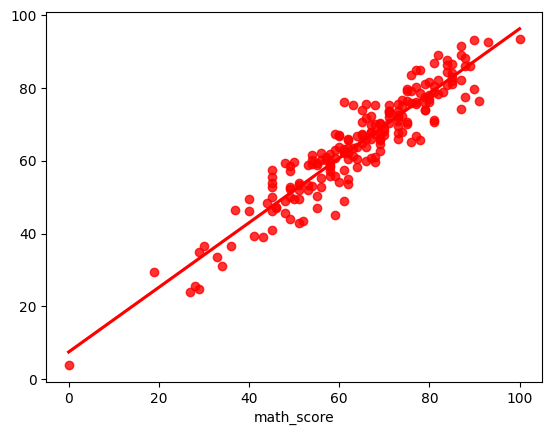

In [38]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

## Difference between Actual and Predicted Values

In [39]:
pred_df = pd.DataFrame({'Actual Values': y_test,
                        'Predicted Values': y_pred,
                        'Difference': y_test-y_pred})
pred_df

,Actual Values,Predicted Values,Difference
521,91,76.398705,14.601295
737,53,58.842469,-5.842469
740,80,76.992129,3.007871
660,74,76.805898,-2.805898
411,84,87.615387,-3.615387
...,...,...,...
408,52,43.492293,8.507707
332,62,62.170763,-0.170763
208,74,67.910325,6.089675
613,65,67.061504,-2.061504


In [41]:
pred_df.describe()

,Actual Values,Predicted Values,Difference
count,200.000000,200.000000,200.000000
mean,64.460000,64.701707,-0.241707
std,15.638453,14.806380,5.398478
min,0.000000,3.906948,-15.278622
25%,55.000000,55.857344,-3.732942
50%,66.000000,65.948480,-0.443847
75%,76.000000,75.566556,3.102536
max,100.000000,93.595832,14.601295
